# Cool Front Image

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d

import pyvista as pv

from hnc.hnc.constants import *


In [3]:
gij_file = "results/CHNC_Al_rs2.998_TeV1.000.dat"
gij_data = read_csv(gij_file, delim_whitespace=True, header=3)
rs = 2.998 # AU
r_data, gei_data = gij_data['r/ri']*rs, gij_data['g_ei']

In [4]:
Al_MD_file = "results/Luciano_Al_checlpoint_10000.npz" 
MD_data = np.load(Al_MD_file)
MD_array = MD_data['pos']*cm_to_AU
MD_data

NpzFile 'results/Luciano_Al_checlpoint_10000.npz' with keys: pos, vel, rdf_hist, species_heat_flux, species_pressure_kin_tensor...

In [5]:
# Radial distribution function g_ei(r)
g_ei = interp1d(r_data, gei_data, fill_value='extrapolate', bounds_error=False)

(0.0, 5.0)

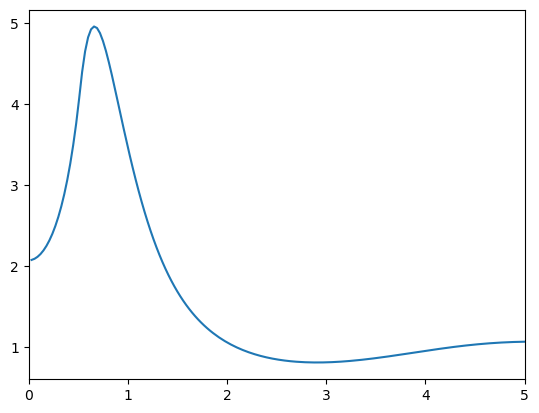

In [6]:
fig, ax = plt.subplots()

ax.plot(r_data, gei_data)
ax.set_xlim(0,5)

In [29]:
%%time

# Constants
L_simulation = 4.360647e-07*cm_to_AU
L = L_simulation/3 # Define smaller box

approx_dx = 0.2
num_points = int(L/approx_dx)


# Ion positions: Nx3 matrix
# Example positions, replace with your actual data
ion_positions = MD_array 

# Create a 3D grid
x = np.linspace(0, L, num_points)
y = np.linspace(0, L, num_points)
z = np.linspace(0, L, num_points)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')

# Compute the electron density at each grid point
electron_density = np.ones((num_points, num_points, num_points))

def min_image_dist(p1, p2, L):
    """ Calculate the minimum image distance accounting for periodic boundary conditions """
    return np.abs(p1 - p2) - L * np.round(np.abs(p1 - p2) / L)

new_ion_MD_array = []
for ion in ion_positions:
    if np.all(ion < L):
        # Calculate distances from this ion to all points in the grid considering periodic boundary conditions
        grid_points = np.column_stack([xx.ravel(), yy.ravel(), zz.ravel()])
        min_image_distances = np.array([min_image_dist(grid_points[:, i], ion[i], L_simulation) for i in range(3)]).T
        distances = np.linalg.norm(min_image_distances, axis=1)
        densities = g_ei(distances).reshape((num_points, num_points, num_points))
        
        # Sum the contributions of this ion's g_ei to the electron density
        electron_density *= densities
        new_ion_MD_array.append(ion)

new_ion_MD_array = np.array(new_ion_MD_array)
# For visualization, you can use your preferred plotting code similar to previous descriptions

CPU times: user 42.3 s, sys: 816 ms, total: 43.1 s
Wall time: 43.1 s


In [44]:
%%time
import numpy as np
from multiprocessing import Pool

# Constants
L_simulation = 4.360647e-07 * cm_to_AU  # Assuming cm_to_AU is defined somewhere
L = L_simulation/4
approx_dx = 0.2
num_points = int(L / approx_dx)

# Example ion positions
ion_positions = MD_array  # Replace with your actual ion positions data

# Create a 3D grid
x = np.linspace(0, L, num_points)
y = np.linspace(0, L, num_points)
z = np.linspace(0, L, num_points)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
grid_points = np.column_stack([xx.ravel(), yy.ravel(), zz.ravel()])

# Function to compute distances accounting for periodic boundary conditions
def min_image_dist(p1, p2, L):
    """ Calculate the minimum image distance accounting for periodic boundary conditions """
    return np.abs(p1 - p2) - L * np.round(np.abs(p1 - p2) / L)

# Function to compute electron density for a subset of ions
def compute_density(ions):
    partial_density = np.ones((num_points, num_points, num_points))
    for ion in ions:
        if np.all(ion < L):
            min_image_distances = np.array([min_image_dist(grid_points[:, i], ion[i], L_simulation) for i in range(3)]).T
            distances = np.linalg.norm(min_image_distances, axis=1)
            densities = g_ei(distances).reshape((num_points, num_points, num_points))
            partial_density *= densities
    return partial_density

# Parallel computation across ion subsets
def parallel_density_calculation(ion_positions, num_processes):
    num_ions_per_process = len(ion_positions) // num_processes
    ion_subsets = np.array([ion_positions[i:i + num_ions_per_process] for i in range(0, len(ion_positions), num_ions_per_process)])
    print(ion_positions.shape)
    print(ion_subsets.shape)
    
    # Map the compute_density function across the ion subsets
    with Pool(processes=num_processes) as pool:
        partial_densities = pool.map(compute_density, ion_subsets)
        
    # Multiply all partial density grids to get the final electron density
    # electron_density = np.ones((num_points, num_points, num_points))
    # for pd in partial_densities:
    #     electron_density *= pd

    return partial_densities#electron_density

# Use this function to calculate electron density
np.array(parallel_density_calculation(ion_positions, num_processes=4)).shape

# Optionally, output final electron density to visualize or analyze further


(5000, 3)
(4, 1250, 3)
CPU times: user 135 ms, sys: 203 ms, total: 338 ms
Wall time: 6.17 s


(4, 103, 103, 103)

In [41]:
from multiprocessing import Pool
import numpy as np

def product_of_numbers(numbers):
    """Function to compute the product of a list of numbers."""
    product = 1
    for number in numbers:
        product *= number
    return product

def main():
    # Range of numbers from 1 to 100
    numbers = list(range(1, 101))
    
    # Number of processes
    num_processes = 4
    
    # Determine the size of each chunk
    chunk_size = len(numbers) // num_processes
    
    # Create chunks of numbers (last chunk takes the remainder)
    chunks = [numbers[i:i + chunk_size] for i in range(0, len(numbers), chunk_size)]
    # Create a pool of workers
    with Pool(processes=num_processes) as pool:
        # Map the product_of_numbers function to each chunk
        results = pool.map(product_of_numbers, chunks)
    
    # Print the results from each process
    for i, result in enumerate(results):
        print(f"Product of chunk {i+1}: {result}")
    
    # Combine the results
    final_product = np.prod(results)
    print(f"Final product of numbers from 1 to 100: {final_product}")

if __name__ == "__main__":
    main()


Product of chunk 1: 15511210043330985984000000
Product of chunk 2: 1960781468160819415703172080467968000000
Product of chunk 3: 815712000579973729423615859451974909952000000
Product of chunk 4: 3761767332187389431968739190317715670695936000000
Final product of numbers from 1 to 100: 93326215443944152681699238856266700490715968264381621468592963895217599993229915608941463976156518286253697920827223758251185210916864000000000000000000000000


In [13]:
# Create a point cloud with ion positions
print(f"{len(new_ion_MD_array)} number of ions in corner")
points = pv.PolyData(new_ion_MD_array)

# Save to a VTK file
points.save("ion_positions.vtk")

71 number of ions in corner


In [14]:

# Example path data: an array of positions (x, y, z) over time
# Replace this with your actual time-sequence position data
path_data = np.array([
    new_ion_MD_array[5],
    new_ion_MD_array[5]*[1.1,1.3,1],
    new_ion_MD_array[5]*[1.1,1.2,1],
    new_ion_MD_array[5]*[1.4,1.4,0.8],
    new_ion_MD_array[5]*[1.3,1.5,0.7]
])

# Create a line representing the path
path = pv.lines_from_points(path_data)

# Save to a VTK file
path.save("particle_path.vtk")

In [15]:
new_ion_MD_array[5]*[1.3,1.5,0.7]

array([11.14831536, 20.77345374,  9.69947879])

In [16]:
# Create a PyVista ImageData object
grid = pv.ImageData()

# Set the dimensions, spacing, and origin of the grid
grid.dimensions = np.array(electron_density.shape) + 1
grid.spacing = (L / (num_points - 1), L / (num_points - 1), L / (num_points - 1))
grid.origin = (0, 0, 0)

# Assign the electron density data to the grid
grid.cell_data["Electron Density"] = electron_density.flatten(order="F")  # Use Fortran order for compatibility with VTK
# grid.cell_data["values"] = values.flatten(order="F")
# grid
# Save the grid to a VTK file
grid.save("electron_density.vtk")


In [ ]:
# import pyvista as pv

# # Constants
# L = 82.5
# num_points = 40

# # Assuming 'electron_density' is your computed 3D numpy array
# # Example data structure for electron_density, replace with your actual data
# electron_density = np.random.rand(num_points, num_points, num_points)

# # Create a PyVista ImageData object
# grid = pv.ImageData()

# # Set the dimensions, spacing, and origin of the grid
# grid.dimensions = np.array(electron_density.shape) + 1
# grid.spacing = (L / (num_points - 1), L / (num_points - 1), L / (num_points - 1))
# grid.origin = (0, 0, 0)

# # Assign the electron density data to the grid
# grid.cell_data["Electron Density"] = electron_density.flatten(order="F")  # Use Fortran order for compatibility with VTK
# # grid.cell_data["values"] = values.flatten(order="F")
# # grid
# # Save the grid to a VTK file
# grid.save("electron_density.vtk")


In [ ]:
# # Plotting
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(ion_positions[:, 0], ion_positions[:, 1], ion_positions[:, 2], color='red', label='Ions')
# ax.scatter(xx.ravel(), yy.ravel(), zz.ravel(), c=electron_density.ravel(), alpha=0.01, label='Electron Density')
# plt.legend()
# plt.title('Electron Density in 3D with Ion Positions')
# plt.show()